### This example demonstrates the XCSF multi-step reinforcement learning mechanisms to solve discrete mazes loaded from a specified input file.

In [1]:
from __future__ import annotations

import os
import random
import sys
from typing import Final

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import xcsf

### Create maze problem class

In [2]:
class Maze:
    """
    Maze problem environment.

    The maze class reads in the chosen maze from a file where each entry
    specifies a distinct position in the maze. The maze is toroidal and if the
    agent/animat reaches one edge it can reenter the maze from the other side.
    Obstacles are coded as 'O' and 'Q', empty positions as '*', and food as 'F'
    or 'G'. The 8 adjacent cells are perceived by the animat and 8 movements
    are possible to one of the adjacent cells (if not blocked.) The animat is
    initially placed at a random empty position. The goal is to find the
    shortest path to the food.

    Some mazes require a form of memory to be solved optimally.
    """

    OPTIMAL: Final[dict] = {
        "woods1": 1.7,
        "woods2": 1.7,
        "woods14": 9.5,
        "maze4": 3.5,
        "maze5": 4.61,
        "maze6": 5.19,
        "maze7": 4.33,
        "maze10": 5.11,
        "woods101": 2.9,
        "woods101half": 3.1,
        "woods102": 3.31,
        "mazef1": 1.8,
        "mazef2": 2.5,
        "mazef3": 3.375,
        "mazef4": 4.5,
    }
    MAX_PAYOFF: Final[float] = 1  #: reward for finding the goal
    X_MOVES: Final[list[int]] = [0, 1, 1, 1, 0, -1, -1, -1]  #: x-axis moves
    Y_MOVES: Final[list[int]] = [-1, -1, 0, 1, 1, 1, 0, -1]  #: y-axis moves

    def __init__(self, filename: str) -> None:
        """Constructs a new maze problem."""
        self.name: Final[str] = filename  #: maze name
        self.maze: list[list[str]] = []  #: maze as read from the input file
        line: list[str] = []
        path = os.path.normpath("../../env/maze/" + filename + ".txt")
        with open(path) as f:
            while True:
                c = f.read(1)
                if not c:
                    break
                if c == "\n":
                    self.maze.insert(0, line)
                    line = []
                else:
                    line.append(c)
        self.x_size: Final[int] = len(self.maze[0])  #: maze width
        self.y_size: Final[int] = len(self.maze)  #: maze height
        self.state: np.ndarray = np.zeros(8)  #: current maze state
        self.x_pos: int = 0  #: current x position within the maze
        self.y_pos: int = 0  #: current y position within the maze

    def reset(self) -> np.ndarray:
        """Resets a maze problem: generating a new random start position."""
        while True:
            self.x_pos = random.randint(0, self.x_size - 1)
            self.y_pos = random.randint(0, self.y_size - 1)
            if self.maze[self.y_pos][self.x_pos] == "*":
                break
        self.update_state()
        return np.copy(self.state)

    def sensor(self, x_pos: int, y_pos: int) -> float:
        """Returns the real-number representation of a discrete maze cell."""
        s: Final[str] = self.maze[y_pos][x_pos]
        if s == "*":
            return 0.1
        if s == "O":
            return 0.3
        if s == "Q":
            return 0.4
        if s == "G":
            return 0.7
        if s == "F":
            return 0.9
        print(f"invalid maze state: {s}")
        sys.exit()

    def update_state(self) -> None:
        """Sets the state to a real-vector representing the sensory input."""
        spos: int = 0
        for i in range(-1, 2):
            for j in range(-1, 2):
                if j == 0 and i == 0:
                    continue
                x = ((self.x_pos + j) % self.x_size + self.x_size) % self.x_size
                y = ((self.y_pos + i) % self.y_size + self.y_size) % self.y_size
                self.state[spos] = self.sensor(x, y)
                spos += 1

    def step(self, act: int) -> tuple[np.ndarray, float, bool]:
        """
        Takes a step in the maze, performing the specified action.
        Returns next state, immediate reward and whether terminal state reached.
        """
        if act < 0 or act > 7:
            print("invalid maze action")
            sys.exit()
        x_vec: Final[int] = Maze.X_MOVES[act]
        y_vec: Final[int] = Maze.Y_MOVES[act]
        x_new: int = ((self.x_pos + x_vec) % self.x_size + self.x_size) % self.x_size
        y_new: int = ((self.y_pos + y_vec) % self.y_size + self.y_size) % self.y_size
        s: Final[str] = self.maze[y_new][x_new]
        if s in ("O", "Q"):
            return np.copy(self.state), 0, False
        self.x_pos = x_new
        self.y_pos = y_new
        self.update_state()
        if s == "*":
            return np.copy(self.state), 0, False
        if s in ("F", "G"):
            return np.copy(self.state), self.max_payoff(), True
        print("invalid maze type")
        sys.exit()

    def optimal(self) -> float:
        """Returns the optimal number of steps to the goal."""
        return Maze.OPTIMAL[self.name]

    def max_payoff(self) -> float:
        """Returns the reward for reaching the goal state."""
        return float(Maze.MAX_PAYOFF)

### Instantiate a new maze problem

In [3]:
maze: Maze = Maze("maze4")

### Initialise XCSF

In [4]:
# initialise XCSF for reinforcement learning
X_DIM: Final[int] = 8
Y_DIM: Final[int] = 1
N_ACTIONS: Final[int] = 8
xcs: xcsf.XCS = xcsf.XCS(X_DIM, Y_DIM, N_ACTIONS)

xcs.OMP_NUM_THREADS = 8
xcs.POP_SIZE = 1000
xcs.PERF_TRIALS = 50
xcs.E0 = 0.001  # target error
xcs.BETA = 0.2  # classifier parameter update rate
xcs.THETA_EA = 25  # EA frequency
xcs.ALPHA = 0.1  # accuracy offset
xcs.NU = 5  # accuracy slope
xcs.EA_SUBSUMPTION = True
xcs.SET_SUBSUMPTION = True
xcs.THETA_SUB = 100  # minimum experience of a subsumer
xcs.action("integer")  # integer actions
xcs.condition("ternary", {"bits": 2})  # ternary conditions: 2-bits per float
xcs.prediction("rls_linear")  # linear recursive least squares predictions

print(xcs.json_parameters())

{
	"version":	"1.1.6",
	"x_dim":	8,
	"y_dim":	1,
	"n_actions":	8,
	"omp_num_threads":	8,
	"pop_init":	true,
	"max_trials":	100000,
	"perf_trials":	50,
	"pop_size":	1000,
	"loss_func":	"mae",
	"gamma":	0.95,
	"teletransportation":	50,
	"p_explore":	0.9,
	"set_subsumption":	true,
	"theta_sub":	100,
	"e0":	0.001,
	"alpha":	0.1,
	"nu":	5,
	"beta":	0.2,
	"delta":	0.1,
	"theta_del":	20,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	25,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	true,
		"pred_reset":	false
	},
	"action":	{
		"type":	"integer"
	},
	"condition":	{
		"type":	"ternary",
		"args":	{
			"p_dontcare":	0.5,
			"bits":	2
		}
	},
	"prediction":	{
		"type":	"rls_linear",
		"args":	{
			"x0":	1,
			"lambda":	1,
			"scale_factor":	1000
		}
	}
}


### Execute experiment

In [5]:
N: Final[int] = 40  # 2,000 trials
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
steps: np.ndarray = np.zeros(N)
error: np.ndarray = np.zeros(N)


def trial(env: Maze, explore: bool) -> tuple[int, float]:
    """Executes a single trial/episode."""
    err: float = 0
    cnt: int = 0
    state: np.ndarray = env.reset()
    xcs.init_trial()
    while cnt < xcs.TELETRANSPORTATION:
        xcs.init_step()
        action = xcs.decision(state, explore)
        next_state, reward, done = env.step(action)
        xcs.update(reward, done)
        err += xcs.error(reward, done, env.max_payoff())
        xcs.end_step()
        cnt += 1
        if done:
            break
        state = next_state
    xcs.end_trial()
    return cnt, err / cnt


def run_experiment(env: Maze) -> None:
    """Executes a single experiment."""
    bar = tqdm(total=N)  # progress bar
    for i in range(N):
        for _ in range(xcs.PERF_TRIALS):
            trial(env, True)  # explore
            cnt, err = trial(env, False)  # exploit
            steps[i] += cnt
            error[i] += err
        steps[i] /= float(xcs.PERF_TRIALS)
        error[i] /= float(xcs.PERF_TRIALS)
        trials[i] = (i + 1) * xcs.PERF_TRIALS
        psize[i] = xcs.pset_size()  # current population size
        msize[i] = xcs.mset_size()  # avg match set size
        status = (  # update status
            f"trials={trials[i]:.0f} "
            f"steps={steps[i]:.2f} "
            f"error={error[i]:.5f} "
            f"psize={psize[i]:.1f} "
            f"msize={msize[i]:.1f}"
        )
        bar.set_description(status)
        bar.refresh()
        bar.update(1)
    bar.close()



run_experiment(maze)

trials=2000 steps=3.62 error=0.00013 psize=845.0 msize=192.2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.05it/s]


### Plot learning performance

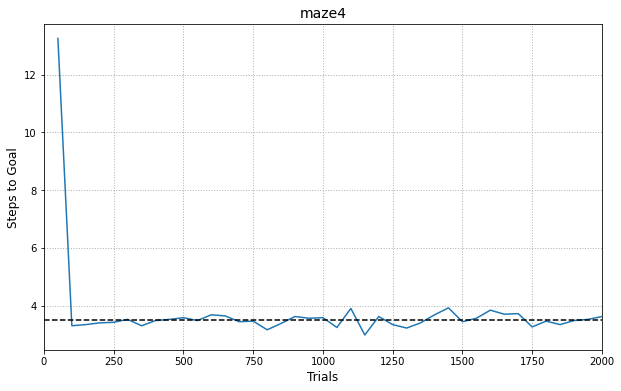

In [6]:
def plot_performance(env: Maze):
    """Plots learning performance."""
    plt.figure(figsize=(10, 6))
    plt.plot(trials, steps)
    plt.grid(linestyle="dotted", linewidth=1)
    plt.axhline(y=env.optimal(), xmin=0, xmax=1, linestyle="--", color="k")
    plt.title(env.name, fontsize=14)
    plt.ylabel("Steps to Goal", fontsize=12)
    plt.xlabel("Trials", fontsize=12)
    plt.xlim([0, N * xcs.PERF_TRIALS])
    plt.show()
    
    
plot_performance(maze)